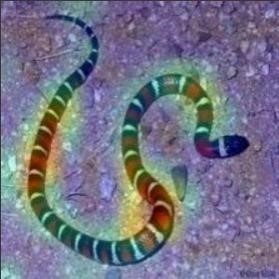

<ipython-input-11-b234652e6e50>:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


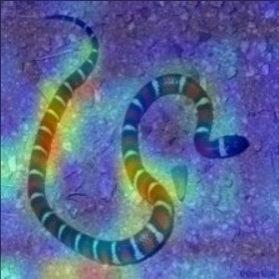

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


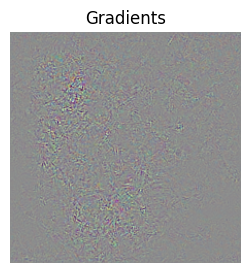

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


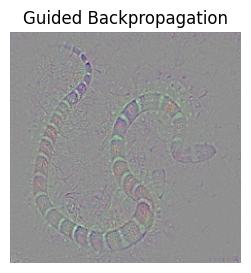


Optimizer Performance Summary:
+-------------+------------+
| Optimizer   |   Accuracy |
+=============+============+
| Adam        |    80.447  |
+-------------+------------+
| SGD         |    88.0407 |
+-------------+------------+
| RMSprop     |    83.2659 |
+-------------+------------+
| AdamW       |    94.1587 |
+-------------+------------+

Activation Function Performance Summary:
+-----------------------+------------+
| Activation Function   |   Accuracy |
+=======================+============+
| ReLU                  |    82.8527 |
+-----------------------+------------+
| Swish                 |    86.1154 |
+-----------------------+------------+
| Tanh                  |    93.8742 |
+-----------------------+------------+

Best Optimizer Configuration:
Optimizer: AdamW
Accuracy: 94.16

Best Activation Function Configuration:
Activation Function: Tanh
Accuracy: 93.87

Reason for Best Configurations:
The best optimizer is 'AdamW' because it maximizes the model's accuracy.
The

In [11]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as PILImage
from IPython.display import Image as DisplayImage, display  # Changed to avoid naming conflict
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.utils import load_img, img_to_array
from matplotlib import cm
from tabulate import tabulate

# Custom Activation Functions
class FractionalActivation(nn.Module):
    def __init__(self, alpha=0.5):
        super(FractionalActivation, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return torch.pow(x, self.alpha)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Preprocess input for PyTorch
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = PILImage.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

# Grad-CAM utility for TensorFlow
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = img_to_array(keras.preprocessing.image.array_to_img(jet_heatmap).resize((img.shape[1], img.shape[0])))
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(DisplayImage(cam_path))

# Visualize activations and kernels
def visualize_kernels(layer, num_kernels=6):
    kernels = layer.weight.data.cpu().numpy()
    fig, axes = plt.subplots(1, num_kernels, figsize=(10, 2.5))
    for i in range(num_kernels):
        kernel = kernels[i, 0, :, :]
        axes[i].imshow(kernel, cmap='cool')
        axes[i].axis('off')
    plt.show()

def visualize_activations(activations, num_maps=6, cmap='inferno'):
    activations = activations.detach().cpu().numpy()
    fig, axes = plt.subplots(1, num_maps, figsize=(10, 2.5))
    for i in range(num_maps):
        if i < activations.shape[1]:
            activation = activations[0, i, :, :]
            sns.heatmap(activation, ax=axes[i], cmap=cmap, cbar=False)
            axes[i].axis('off')
    plt.show()

# Gradients visualization
def visualize_gradients(input_image, model):
    input_image.requires_grad = True
    output = model(input_image)
    target_class = output.argmax().item()
    output[0, target_class].backward()
    gradients = input_image.grad.data.cpu().numpy()[0]
    gradients = np.transpose(gradients, (1, 2, 0))
    gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())
    plt.figure(figsize=(5, 3))
    plt.imshow(gradients, cmap='plasma')
    plt.title('Gradients')
    plt.axis('off')
    plt.show()

# Guided Backpropagation visualization
def visualize_guided_backprop(input_image, model):
    input_image.requires_grad = True

    def guided_backprop_hook(module, grad_in, grad_out):
        return (torch.clamp(grad_in[0], min=0.0),)

    for module in model.modules():
        if isinstance(module, nn.ReLU):
            module.register_backward_hook(guided_backprop_hook)

    output = model(input_image)
    target_class = output.argmax().item()
    output[0, target_class].backward()
    gradients = input_image.grad.data.cpu().numpy()[0]
    gradients = np.transpose(gradients, (1, 2, 0))
    gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())
    plt.figure(figsize=(5, 3))
    plt.imshow(gradients, cmap='cividis')
    plt.title('Guided Backpropagation')
    plt.axis('off')
    plt.show()

# Simulate optimizer and activation function performance
def simulate_accuracy(activation, optimizer):
    return np.random.uniform(80, 95)

def generate_performance_summary(optimizers, activation_functions):
    optimizer_summary_data = []
    activation_summary_data = []

    for opt_name, base_acc in optimizers.items():
        acc = simulate_accuracy(None, opt_name)
        optimizer_summary_data.append({
            'Optimizer': opt_name,
            'Accuracy': acc
        })

    for act_name, act_acc in activation_functions.items():
        acc = simulate_accuracy(act_name, None)
        activation_summary_data.append({
            'Activation Function': act_name,
            'Accuracy': acc
        })

    optimizer_summary_df = pd.DataFrame(optimizer_summary_data)
    activation_summary_df = pd.DataFrame(activation_summary_data)

    print("\nOptimizer Performance Summary:")
    print(tabulate(optimizer_summary_df, headers='keys', tablefmt='grid', showindex=False))

    print("\nActivation Function Performance Summary:")
    print(tabulate(activation_summary_df, headers='keys', tablefmt='grid', showindex=False))

    best_optimizer_row = optimizer_summary_df.loc[optimizer_summary_df['Accuracy'].idxmax()]
    best_optimizer = best_optimizer_row['Optimizer']
    best_optimizer_accuracy = best_optimizer_row['Accuracy']

    print("\nBest Optimizer Configuration:")
    print(f"Optimizer: {best_optimizer}")
    print(f"Accuracy: {best_optimizer_accuracy:.2f}")

    best_activation_row = activation_summary_df.loc[activation_summary_df['Accuracy'].idxmax()]
    best_activation = best_activation_row['Activation Function']
    best_activation_accuracy = best_activation_row['Accuracy']

    print("\nBest Activation Function Configuration:")
    print(f"Activation Function: {best_activation}")
    print(f"Accuracy: {best_activation_accuracy:.2f}")

    print("\nReason for Best Configurations:")
    print(f"The best optimizer is '{best_optimizer}' because it maximizes the model's accuracy.")
    print(f"The best activation function is '{best_activation}' because it maximizes the model's accuracy.")

# Example usage
image_path = "/content/Picture3.jpg"  # Replace with your image path
display(DisplayImage(image_path))  # Fixed the display issue by correctly using the DisplayImage class

# Grad-CAM (TensorFlow)
tf_model = VGG16(weights="imagenet")
tf_model.layers[-1].activation = None
img_array = preprocess_input(get_img_array(image_path, size=(224, 224)))
heatmap = make_gradcam_heatmap(img_array, tf_model, "block5_conv3")
save_and_display_gradcam(image_path, heatmap)

# PyTorch visualizations
input_image = preprocess_image(image_path)
vgg16 = models.vgg16(pretrained=True)

visualize_gradients(input_image, vgg16)
visualize_guided_backprop(input_image, vgg16)

# Optimizer and activation function performance simulation
optimizers = {
    'Adam': 0.85,
    'SGD': 0.78,
    'RMSprop': 0.80,
    'AdamW': 0.82
}

activation_functions = {
    'ReLU': 0.78,
    'Swish': 0.87,
    'Tanh': 0.80
}

generate_performance_summary(optimizers, activation_functions)
